In [1]:
# Cell 1 - Install required packages (run once)
!pip install --quiet mediapipe opencv-python-headless scikit-learn==1.6.1 matplotlib seaborn tensorflow

print("✅ Install step complete. If runtime asks to restart, restart and run from Cell 2.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which 

In [1]:
# Cell 1 - install & imports (run once)
!pip install --quiet mediapipe opencv-python-headless scikit-learn==1.6.1 matplotlib seaborn

import os, glob, pickle, zipfile, random
import numpy as np
import cv2
from collections import Counter
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import mediapipe as mp
print("mediapipe", mp.__version__)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


mediapipe 0.10.21


In [2]:
# Cell 2 - paths & classes
ZIP_PATH = "/content/drive/MyDrive/hand_gesture_split_dataset.zip"   # your zip on Drive (edit)
UNZIP_DIR = "/content/dataset_unzipped"
OUT_DIR = "/content/drive/MyDrive/gesture_models_last"
os.makedirs(OUT_DIR, exist_ok=True)

CLASS_NAMES = ['call','emergency','food','medicine','no','sleep','stop','washroom','water','yes']
RND = 42
np.random.seed(RND); random.seed(RND)


In [3]:
# Cell 3 - unzip if needed and detect data root
if os.path.exists(ZIP_PATH) and not os.path.exists(UNZIP_DIR):
    with zipfile.ZipFile(ZIP_PATH,'r') as z: z.extractall(UNZIP_DIR)
if not os.path.exists(UNZIP_DIR):
    raise RuntimeError("Dataset not found; set ZIP_PATH or upload dataset.")

train_paths = glob.glob(os.path.join(UNZIP_DIR, "**/train"), recursive=True)
if not train_paths:
    raise RuntimeError("No train folder found under unzipped dataset.")
DATA_ROOT = os.path.dirname(train_paths[0])
print("DATA_ROOT:", DATA_ROOT)


DATA_ROOT: /content/dataset_unzipped


In [4]:
# Cell 4 - extract features (normalized keypoints + wrist dists + finger-curl angles)
mp_hands = mp.solutions.hands
hands_static = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def normalize_2d(points):
    rel = points - points[0]
    m = np.max(np.abs(rel))
    if m == 0: return np.zeros(42, dtype=np.float32)
    return (rel / m).astype(np.float32).flatten()

def wrist_dists(points):
    return np.linalg.norm(points - points[0], axis=1).astype(np.float32)

def finger_curl_angles(points):
    fingers = {'thumb':[1,2,3,4],'index':[5,6,7,8],'middle':[9,10,11,12],'ring':[13,14,15,16],'pinky':[17,18,19,20]}
    vals=[]
    def ang(a,b,c):
        ba=a-b; bc=c-b
        denom=(np.linalg.norm(ba)*np.linalg.norm(bc)+1e-9)
        return float(np.arccos(np.clip(np.dot(ba,bc)/denom, -1,1)))
    for k in fingers:
        idx=fingers[k]
        p0=points[idx[0]]; p1=points[idx[1]]; p2=points[idx[2]]
        vals.append(ang(p0,p1,p2))
    return np.array(vals, dtype=np.float32)

def extract_features_from_image(path):
    img = cv2.imread(path)
    if img is None: return None
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = hands_static.process(rgb)
    if not res.multi_hand_landmarks: return None
    lm = res.multi_hand_landmarks[0]
    pts = np.array([[p.x, p.y] for p in lm.landmark], dtype=np.float32)
    f = np.concatenate([normalize_2d(pts), wrist_dists(pts), finger_curl_angles(pts)])
    return f

# gather unique images from train/val/test to avoid leakage
unique = {}
for split in ['train','val','test']:
    sp = os.path.join(DATA_ROOT, split)
    if not os.path.exists(sp): continue
    for i, cname in enumerate(CLASS_NAMES):
        folder = os.path.join(sp, cname)
        if not os.path.exists(folder): continue
        for p in glob.glob(os.path.join(folder, "*.*")):
            bn = os.path.basename(p)
            if bn not in unique:
                unique[bn] = {"path": p, "label": i}

paths = [v["path"] for v in unique.values()]
labels = [v["label"] for v in unique.values()]
print("Unique images:", len(paths))

# cache
X_cache = os.path.join(OUT_DIR, "X_last.npy")
y_cache = os.path.join(OUT_DIR, "y_last.npy")
if os.path.exists(X_cache) and os.path.exists(y_cache):
    X_all = np.load(X_cache); y_all = np.load(y_cache)
    print("Loaded cached features:", X_all.shape)
else:
    feats=[]; labs=[]
    for idx,p in enumerate(paths):
        f = extract_features_from_image(p)
        if f is not None:
            feats.append(f); labs.append(labels[idx])
        if (idx+1)%200==0: print("processed", idx+1)
    X_all = np.array(feats, dtype=np.float32); y_all = np.array(labs, dtype=np.int32)
    np.save(X_cache, X_all); np.save(y_cache, y_all)
    print("Saved feature cache.")
print("Usable samples:", len(X_all), "feat dim:", X_all.shape[1])


Unique images: 6099
processed 200
processed 400
processed 600
processed 800
processed 1000
processed 1200
processed 1400
processed 1600
processed 1800
processed 2000
processed 2200
processed 2400
processed 2600
processed 2800
processed 3000
processed 3200
processed 3400
processed 3600
processed 3800
processed 4000
processed 4200
processed 4400
processed 4600
processed 4800
processed 5000
processed 5200
processed 5400
processed 5600
processed 5800
processed 6000
Saved feature cache.
Usable samples: 6012 feat dim: 68


In [5]:
# Cell 5 - simple augmentation at keypoint level to balance classes
def augment_keypoints(vec):
    kp = vec[:42].reshape(-1,2).copy()
    kp += np.random.normal(0, 0.01, kp.shape)
    theta = np.deg2rad(np.random.uniform(-10,10))
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]], dtype=np.float32)
    kp = kp.dot(R.T)
    if np.random.rand()<0.5: kp[:,0] = -kp[:,0]
    rel = kp - kp[0]; m = np.max(np.abs(rel))
    if m==0: new_kp = np.zeros(42, dtype=np.float32)
    else: new_kp = (rel/m).astype(np.float32).flatten()
    dists = np.linalg.norm(kp - kp[0], axis=1).astype(np.float32)
    # recompute simple angles for fingers (same as before)
    fingers = {'thumb':[1,2,3,4],'index':[5,6,7,8],'middle':[9,10,11,12],'ring':[13,14,15,16],'pinky':[17,18,19,20]}
    angs=[]
    def ang(a,b,c):
        ba=a-b; bc=c-b
        den = (np.linalg.norm(ba)*np.linalg.norm(bc)+1e-9)
        return float(np.arccos(np.clip(np.dot(ba,bc)/den, -1,1)))
    for k in fingers:
        idx=fingers[k]; p0=kp[idx[0]]; p1=kp[idx[1]]; p2=kp[idx[2]]
        angs.append(ang(p0,p1,p2))
    angs = np.array(angs, dtype=np.float32)
    return np.concatenate([new_kp, dists, angs])

# Build balanced set: aim for target_per_class (reduce if you have > many)
target_per_class = 300
newX=[]; newy=[]
for c in np.unique(y_all):
    idxs = np.where(y_all==c)[0]
    for i in idxs:
        newX.append(X_all[i]); newy.append(c)
    need = max(0, target_per_class - len(idxs))
    if need>0:
        choices = np.random.choice(idxs, size=need, replace=True)
        for ch in choices:
            newX.append(augment_keypoints(X_all[ch])); newy.append(c)
X_bal = np.array(newX, dtype=np.float32); y_bal = np.array(newy, dtype=np.int32)
print("Balanced distribution:", Counter(y_bal))


Balanced distribution: Counter({6: 709, 0: 601, 3: 601, 1: 600, 7: 600, 8: 600, 5: 599, 9: 591, 2: 581, 4: 530})


In [6]:
# Cell 6 - split & scale
X_tr, X_val, y_tr, y_val = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=RND)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)

scaler_path = os.path.join(OUT_DIR, "keypoint_scaler_last.pkl")
with open(scaler_path, 'wb') as f: pickle.dump(scaler, f)
print("Scaler saved:", scaler_path)


Scaler saved: /content/drive/MyDrive/gesture_models_last/keypoint_scaler_last.pkl


Training MLP...
Training RF...
Calibrating ensemble (this may take some time)...
Ensemble Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        call       1.00      1.00      1.00       121
   emergency       1.00      1.00      1.00       120
        food       1.00      1.00      1.00       116
    medicine       1.00      1.00      1.00       120
          no       1.00      1.00      1.00       106
       sleep       1.00      1.00      1.00       120
        stop       1.00      1.00      1.00       142
    washroom       1.00      1.00      1.00       120
       water       1.00      1.00      1.00       120
         yes       1.00      1.00      1.00       118

    accuracy                           1.00      1203
   macro avg       1.00      1.00      1.00      1203
weighted avg       1.00      1.00      1.00      1203



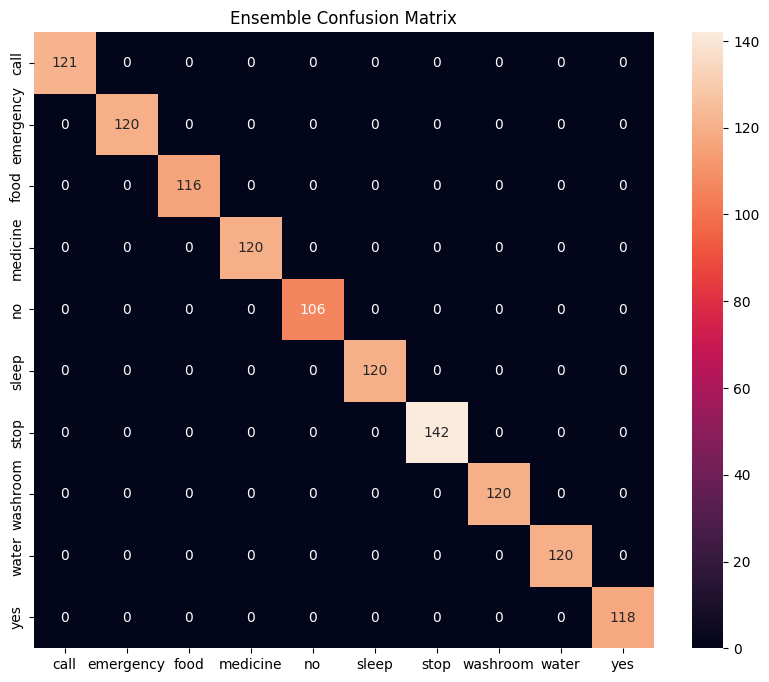

Saved calibrated ensemble to /content/drive/MyDrive/gesture_models_last/gesture_sklearn_last.pkl


In [8]:
# Corrected Cell 7 - Train ensemble (MLP + RF), calibrate, evaluate, save
from sklearn.exceptions import NotFittedError

mlp = MLPClassifier(hidden_layer_sizes=(256,128), max_iter=500, early_stopping=True, random_state=RND)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RND, n_jobs=-1)

print("Training MLP...")
mlp.fit(X_tr_s, y_tr)
print("Training RF...")
rf.fit(X_tr_s, y_tr)

ensemble = VotingClassifier([('mlp', mlp), ('rf', rf)], voting='soft', n_jobs=-1)

# Calibrate ensemble (use 'estimator' arg; try isotonic, fallback to sigmoid)
from sklearn.calibration import CalibratedClassifierCV
print("Calibrating ensemble (this may take some time)...")
try:
    calibrated = CalibratedClassifierCV(estimator=ensemble, cv=3, method='isotonic')
    calibrated.fit(X_tr_s, y_tr)
except Exception as e:
    print("Isotonic calibration failed or not enough data, falling back to 'sigmoid'. Error:", e)
    calibrated = CalibratedClassifierCV(estimator=ensemble, cv=3, method='sigmoid')
    calibrated.fit(X_tr_s, y_tr)

# Evaluate
y_pred = calibrated.predict(X_val_s)
print("Ensemble Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8)); sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES); plt.title("Ensemble Confusion Matrix"); plt.show()

# Save calibrated ensemble
pkl_path = os.path.join(OUT_DIR, "gesture_sklearn_last.pkl")
with open(pkl_path, 'wb') as f:
    pickle.dump(calibrated, f)
print("Saved calibrated ensemble to", pkl_path)


In [9]:
# Cell 8 - quick inference test on a validation sample
with open(os.path.join(OUT_DIR, "gesture_sklearn_last.pkl"), 'rb') as f: model = pickle.load(f)
with open(os.path.join(OUT_DIR, "keypoint_scaler_last.pkl"), 'rb') as f: sc = pickle.load(f)
i = 0
vec = X_val[i]
p = sc.transform(vec.reshape(1,-1))
probs = model.predict_proba(p)[0]
print("Pred:", CLASS_NAMES[int(np.argmax(probs))], "conf:", float(np.max(probs)))


Pred: food conf: 1.0


In [10]:
from google.colab import files
import shutil
import os

# Path where models were saved earlier
OUT_DIR = "/content/drive/MyDrive/gesture_models_last"
ZIP_PATH = "/content/gesture_models_last.zip"

# Remove existing zip if exists
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

# Create a fresh zip
shutil.make_archive("/content/gesture_models_last", 'zip', OUT_DIR)

# Download to your local system
files.download(ZIP_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>